# Preliminaries

In [ ]:
dataset_file = "ElectricityConsumptionHourly.csv"  # ElectricityConsumptionHourly.csv
column_name = "MT_163"
LIMH, LIML = 4300, 700
workers_num: int = 1

# Sequences length config
features_size: int = 1
covariates_size: int = 0
history_len: int = 24
horizon_len: int = 3
quantiles: List[float] = [0.1, 0.9]

# Model config
batch_len: int = 64
num_layers: int = 5 # Number of layers in LSTM
hidden_units: int = 64
context_size: int = 12

## Installs and imports

In [ ]:
# Uncomment these lines when running on TPU
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
!pip install pytorch-lightning --quiet

In [ ]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12,4)
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from typing import List

torch.manual_seed(1995)
selected_device = "cuda"  # Use "cuda" for GPU, "cpu" for CPU or "tpu" for TPU
print(f'Python Version: {sys.version}')
print(f'Pytorch Version: {torch.__version__}')

if torch.cuda.is_available():
  print(f'CUDA Version: {torch.version.cuda}')
  print(f'GPU count: {torch.cuda.device_count()}')
  print(f'GPU: {torch.cuda.get_device_name(0)}')

Populating the interactive namespace from numpy and matplotlib
Python Version: 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Pytorch Version: 1.7.1+cu101
CUDA Version: 10.1
GPU count: 1
GPU: Tesla K80


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Data Module

## Loading the dataset

In [ ]:
first_run = True

In [ ]:
elec_df = pd.read_csv(dataset_file, parse_dates=["timestamp"], 
                      index_col="timestamp", delimiter=",")
elec_df = elec_df.drop(["Unnamed: 0"], axis=1)

if not first_run:  # Aggregating for hourly time-stamps.
    elec_df = elec_df.resample('1H', on="timestamp").mean()

##Fixing issues of uniqueness, monotonicity and missing-values

In [ ]:
# Verifying monotonicity
if elec_df.index.is_monotonic:
  elec_df = elec_df.sort_index()

# Verify index uniqueness
if elec_df.index.is_unique:
  elec_df = elec_df[~elec_df.index.duplicated(keep='first')]

# Fix missing-values, if there are any
if elec_df.isnull().values.any():
    print(f'Total missing values: {elec_df.isnull().sum().sum()}')

    # Missing-values are replaced by the last valid observation
    elec_df.ffill(inplace=True)
else:
  print(f'No missing-values in the data-frame!')

print(f'Is index monotonic? {elec_df.index.is_monotonic}')
print(f'Is index unique? {elec_df.index.is_unique}')
elec_df.head()

No missing-values in the data-frame!
Is index monotonic? True
Is index unique? True


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.385802,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114.583333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112.268519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,112.847222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Using a Pytorch Dataset

In [ ]:
class ElectricityDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df, samples: int, hist_len: int = 168, fct_len: int = 24, 
                 col="MT_001"):
        self.hist_num: int = hist_len
        self.fct_num: int = fct_len
        self.hist_len = pd.Timedelta(hours=hist_len)
        self.fct_len = pd.Timedelta(hours=fct_len)
        self.offset = pd.Timedelta(hours=1)

        self.max_ts = df.index.max() - self.hist_len - self.fct_len + self.offset
        self.raw_data = df

        assert samples <= self.raw_data[:self.max_ts].shape[0]
        self.samples = samples
        self.col = col
        self.sample()

    def sample(self):
        """Sample individual series as needed."""
        self.sample_idx = (self
                           .raw_data[:self.max_ts]
                           .index
                           .to_series()
                           .sample(self.samples, replace=False, random_state=1995)
                           .index)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        start_ts = self.sample_idx[idx]

        hs, he = start_ts, start_ts + self.hist_len - self.offset
        fs, fe = he + self.offset, he + self.fct_len

        hist_data = self.raw_data[hs:].iloc[:self.hist_num]
        fct_data = self.raw_data[fs:].iloc[:self.fct_num]

        return (torch.Tensor(hist_data[self.col].values),
                torch.Tensor(fct_data[self.col].values))

## Pytorch-lightning DataModule

In [ ]:
class ElectricityDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, df, history_len, horizon_len,
                 train_range=("2011", "2013"),
                 val_range=("2013","2014"),
                 test_range=("2014", None),
                 factor=0.5,
                 batch_size=64,
                 workers=1,
                 col=column_name):

        super().__init__()
        self.raw_data = df
        self.train_range = train_range
        self.val_range = val_range
        self.test_range = test_range
        self.factor = factor
        self.batch_size = batch_size
        self.workers = workers
        self._history_len: int = history_len
        self._horizon_len: int = horizon_len

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_df = self.raw_data[slice(*self.train_range)]
            val_df = self.raw_data[slice(*self.val_range)]

            self.train_ds = ElectricityDataset(train_df, col=column_name,
                                               fct_len=self._horizon_len,
                                               hist_len=self._history_len,
                                               samples=int(self.factor * train_df.shape[0]))
            self.val_ds = ElectricityDataset(val_df, col=column_name,
                                             fct_len=self._horizon_len,
                                             hist_len=self._history_len,
                                             samples=int(self.factor * val_df.shape[0]))
            print(f'Train set size: {int(self.factor * train_df.shape[0])}')
            print(f'Val set size: {int(self.factor * val_df.shape[0])}')

        if stage == "test" or stage is None:
            test_df = self.raw_data[slice(*self.test_range)]
            self.test_ds = ElectricityDataset(test_df, col=column_name,
                                              fct_len=self._horizon_len,
                                              hist_len=self._history_len,
                                              samples=int(self.factor * test_df.shape[0]))
            print(f'Test set size: {int(self.factor * test_df.shape[0])}')

    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [ ]:
ds = ElectricityDataset(elec_df, samples=10)
print(f'Input sequence length: {list(ds[3][0].shape)[0]}')
print(f'Output sequence length: {list(ds[3][1].shape)[0]}')

Input sequence length: 168
Output sequence length: 24


# Encoder Network

In [ ]:
class Encoder(pl.LightningModule):
    """Encoder network for encoder-decoder forecast model."""
   
    def __init__(self, n_features: int = 1, n_covariates: int = 0,
                 num_layers: int = 1, hidden_units: int = 8):
        super().__init__()
        self._n_features: int = n_features
        self._n_covariates: int = n_covariates
        self._num_layers: int = num_layers
        self._hidden_units: int = hidden_units

        self.encoder = nn.LSTM(input_size=self._n_features + n_covariates,
                               hidden_size=self._hidden_units,
                               num_layers=self._num_layers,
                               batch_first=True)

    def forward(self, y, covariates = None, is_train: bool = False):
        """
        Args:
          y is [batch_size, seq_len, n_features] or [seq_len, n_features]
          covariates is [batch_size, seq_len, covariates_size] or [seq_len, covariates_size]
          is_train(bool): A flag is True if this is part of the training stage.

        Output:
          tensor of [batch_size, seq_len, hidden_size] or 
            [batch_size, hidden_size], if is_train is True.
        """
        is_input_2d: bool = len(y.shape) == 2
        if is_input_2d:  # For inference on a single sample
            y = y.view((1, y.shape[0], y.shape[1]))
            covariates = covariates.view((1, covariates.shape[0], 
                                          covariates.shape[1]))
        y_ten = torch.cat((y, covariates), dim=2)
        output, _ = self.encoder(y_ten)   

        # For inference, only the last hidden-state is used.
        # For training, all hidden-states are returned.
        if not is_train:
            output = output[:, -1, :]     
        return output


In [ ]:
encoder = Encoder(features_size, covariates_size, num_layers, hidden_units)
#hist_sample = torch.cat([ds[3][0].unsqueeze(0),
#                         ds[5][0].unsqueeze(0)])

#fct_sample = torch.cat([ds[3][1].unsqueeze(0),
#                        ds[5][1].unsqueeze(0)])
hist_sample = torch.ones(batch_len, history_len, features_size)
cov = torch.zeros(batch_len, history_len, covariates_size)
print(hist_sample.shape)
output = encoder(hist_sample, cov, is_train=False)
print(f'All inputs shape: {list(hist_sample.shape)}')
print(f'All outputs shape: {list(output.shape)}')

torch.Size([64, 24, 1])
All inputs shape: [64, 24, 1]
All outputs shape: [64, 64]


# Decoder Network

## Global Decoder

In [ ]:
class GlobalDecoder(pl.LightningModule):
    def __init__(self, n_features: int = 1, n_covariates: int = 0,
                 prediction_len: int = 1, context_size: int = 1,
                 hidden_units: int = 8, 
                 inner_layers_sizes: List = [1, 1]):
        super().__init__()
        self._context_size: int = context_size
        self._prediction_len: int = prediction_len
        self._input_params_num: int = n_features * hidden_units + \
          n_covariates * prediction_len
        self._output_params_num: int = (prediction_len + 1) * context_size
        sizes_list = [self._input_params_num] + inner_layers_sizes + \
          [self._output_params_num]

        self._layers = nn.ModuleList()
        for size1, size2 in zip(sizes_list, sizes_list[1:]):
            self._layers.append(nn.Linear(in_features=size1, out_features=size2))
        self._activation = F.relu

    def forward(self, encoder_output, future_covariates=None):
        """
        Args:
          encoder_output is [batch_size, hidden_size]
          covariates is [batch_size, prediction_len, covariates_size]
          is_train(bool): A flag is True if this is part of the training stage.

        Output:
          (prediction_len + 1) tensors of size [batch_size, seq_len, context_size]
        """
        future_covariates = torch.flatten(future_covariates, start_dim=1)
        x = torch.cat((encoder_output, future_covariates), dim=1)
        for layer in self._layers:
            x = self._activation(layer(x))
        return torch.split(x, self._context_size, dim=1)

## Local Decoder

In [ ]:
class LocalDecoder(pl.LightningModule):
    def __init__(self, n_features: int = 1, n_covariates: int = 0, 
                 n_quantiles: int = 1, context_size: int = 1, 
                 hidden_units: int = 8, inner_layers_sizes: List = [1]):
        super().__init__()
        self._n_features: int = n_features
        self._hidden_units: int = hidden_units
        self._input_params_num: int = 2 * context_size + n_covariates
        self._output_params_num: int = n_features * n_quantiles
        sizes_list = [self._input_params_num] + inner_layers_sizes + \
            [self._output_params_num]

        self._layers = nn.ModuleList()
        for size1, size2 in zip(sizes_list, sizes_list[1:]):
            self._layers.append(nn.Linear(in_features=size1, out_features=size2))
        self._activation = F.relu

    def forward(self, agnostic_context, specific_context,
                specific_future_covariate):
        """
        Args:
          agnostic_context is [batch_size, context_size]
          specific_context is [batch_size, context_size]
          specific_future_covariate is [batch_size, n_covariates]

        Returns:
          A tensor of [batch_size, n_quantiles]
        """
        x = torch.cat((agnostic_context, specific_context, 
                       specific_future_covariate), dim=1)
        for layer in self._layers:
            x = self._activation(layer(x))
        x = x.view((x.shape[0], self._n_features, 
                    int(x.shape[1] / self._n_features)))
        return x

## Entire Decoder

In [ ]:
class Decoder(pl.LightningModule):
    """Decoder network for encoder-decoder forecast model."""
   
    def __init__(self, n_features: int = 1, n_covariates: int = 0, 
                 n_quantiles: int = 1, context_size: int = 1, 
                 hidden_units: int = 8, prediction_len: int = 1,
                 global_decoder_layers_sizes: List = [1, 1],
                 local_decoder_layers_sizes: List = [1]):
        super().__init__()
        self._n_features: int = n_features
        self.num_layers: int = num_layers
        self.hidden_units: int = hidden_units

        self._decoders = nn.ModuleList([
          GlobalDecoder(n_features, n_covariates, prediction_len, context_size,
                        hidden_units, global_decoder_layers_sizes),
          LocalDecoder(n_features, n_covariates, n_quantiles, context_size, 
                       hidden_units, local_decoder_layers_sizes)
        ])

    def forward(self, encoder_output, future_covariates=None):
        """
        Args:
          encoder_output is [batch_size, hidden_size]
          future_covariates is [batch_size, prediction_len, n_covariates]

        Returns:
          A tensor of [batch_size, prediction_len, n_quantiles]
        """
        contexts = self._decoders[0](encoder_output, future_covariates)
        agnostic_context = contexts[0]
        specific_contexts = contexts[1:]
        quantiles_estimation = []
        for i, time_specific_context in enumerate(specific_contexts):
            current_horizon_covariate = future_covariates[:, i, :]
            current_horizon_quantiles = self._decoders[1](
                agnostic_context, time_specific_context, 
                current_horizon_covariate)
            current_horizon_quantiles = torch.unsqueeze(
                current_horizon_quantiles, dim=1)
            quantiles_estimation.append(current_horizon_quantiles)
        all_quantiles = torch.cat(quantiles_estimation, dim=1)
        return all_quantiles

In [ ]:
d = GlobalDecoder(features_size, covariates_size, horizon_len, 
                  context_size, hidden_units, inner_layers_sizes=[100, 100])
t = Decoder(features_size, covariates_size, len(quantiles), context_size, 
            hidden_units, horizon_len,
            global_decoder_layers_sizes=[100, 100],
            local_decoder_layers_sizes=[100])

print(f'shape:{output.shape}')
empty_cov = torch.empty((batch_len, horizon_len, covariates_size))
r = d(output, empty_cov)
out_agnostic_context = r[0]
out_specific_contexts = r[1:]
for i, rr in enumerate(out_specific_contexts):
  print(rr.shape)
print(output.shape)
t(output, empty_cov).shape

shape:torch.Size([64, 64])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64, 16])
torch.Size([64, 64])


torch.Size([64, 3, 1, 2])

# MQRNN Model

In [ ]:
class MQRNN(pl.LightningModule):
    """Entire MQ-RNN model"""
   
    def __init__(self, quantiles: List[float], hist_len: int = 3, 
                 fct_len: int = 24, n_features: int = 1, n_covariates: int = 0, 
                 num_layers: int = 1, hidden_units: int = 8, 
                 context_size : int = 1, 
                 global_mlp_layers_sizes: List[int] = [100, 100],
                 local_mlp_layers_sizes: List[int] = [100],
                 lr: float = 1e-1):
        super().__init__()
        self._hist_len: int = hist_len
        self._fct_len: int = fct_len
        self._n_features: int = n_features
        self._quantiles: List[float] = quantiles

        self.num_layers: int = num_layers
        self.hidden_units: int = hidden_units
        self.lr: float = lr

        self._encoder = Encoder(n_features, n_covariates, num_layers, 
                                hidden_units)
        self._decoder = Decoder(n_features, n_covariates, len(quantiles), 
                                context_size, hidden_units, horizon_len,
                                global_mlp_layers_sizes,
                                local_mlp_layers_sizes)

    def forward(self, x, covariates = None, is_train: bool = False):
        if covariates is None:
            current_covariates = torch.empty((x.shape[0], self._hist_len, 0),
                                             device = self.device)
            future_covariates = torch.empty((x.shape[0], self._fct_len, 0),
                                            device = self.device)
        else:
            current_covariates, future_covariates = torch.split(
                covariates, [self._hist_len, self._fct_len], dim=1)
        encoder_output = self._encoder(x, current_covariates, is_train)

        if is_train:
            forecasts = []
            for timestamp_index in range(self._hist_len):
                encoder_specific_output = encoder_output[:,timestamp_index,...]
                specific_forecast = self._decoder(encoder_specific_output, 
                                                  future_covariates)
                forecasts.append(torch.unsqueeze(specific_forecast, dim=3))
            forecasts = torch.cat(forecasts, dim=3)
        else:
            forecasts = self._decoder(encoder_output, future_covariates)
        return forecasts

    def _quantile_loss(self, y_pred, target):
        """
        Args:
          y_pred is [batch_size, prediction_len, n_features, quantiles_len]
          target is [batch_size, prediction_len, n_features]
        
        Returns:
          A tensor of [batch_size, prediction_len, n_features, quantiles_len]
        """
        losses = []
        for i, q in enumerate(self._quantiles):
            errors = target - y_pred[..., i]
            losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(-1))
        losses = torch.cat(losses, dim=3)

        return losses

    def total_quantile_loss(self, y_pred, target):
        """
        Args:
          y_pred is [batch_size, prediction_len, n_features, quantiles_len]
          target is [batch_size, prediction_len, n_features]
        
        Returns:
          A float, the sum of all the quantile-losses
        """
        total_loss = torch.zeros((1), device=self.device)
        for t in range(y_pred.shape[3]):
          ground_truth = target[:,t:t+self._fct_len, ...]
          predictions = y_pred[:,:,:,t,:]
          current_loss = self._quantile_loss(predictions, ground_truth)
          total_loss += torch.sum(torch.flatten(current_loss))
        total_loss /= y_pred.shape[0]
        return total_loss

    def _prepare_batch(self, batch):
        x, y = batch
        if self._n_features == 1:
            x = torch.unsqueeze(x, dim=2)
            y = torch.unsqueeze(y, dim=2)
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = self._prepare_batch(batch)
        forecasts = self(x, is_train=True)
        all_series = torch.cat((x, y), dim=1)
        loss = self.total_quantile_loss(forecasts, all_series)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = self._prepare_batch(batch)
        forecasts = self(x, is_train=False)
        forecasts = torch.unsqueeze(forecasts, dim=3)
        loss = self.total_quantile_loss(forecasts, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = self._prepare_batch(batch)
        forecasts = self(x, is_train=False)
        forecasts = torch.unsqueeze(forecasts, dim=3)
        loss = self.total_quantile_loss(forecasts, y)
        self.log('test_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

# Training the Model

In [ ]:
def scale(df, lower_lim, upper_lim):
  return (2 * df - lower_lim - upper_lim) / (upper_lim - lower_lim)

def un_scale(df, lower_lim, upper_lim):
  return (df * (upper_lim - lower_lim) + (upper_lim + lower_lim)) / 2

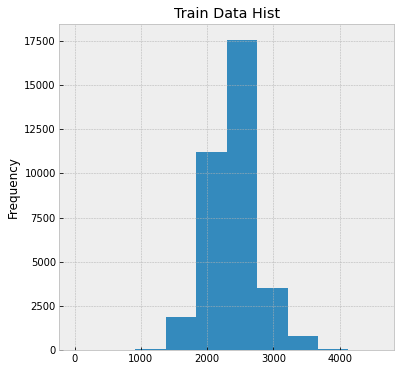

In [ ]:
plt.figure(figsize=(6,6))
elec_df[column_name].plot(kind="hist", ax=plt.gca(), title="Train Data Hist")
elec_df_norm = scale(elec_df, LIML, LIMH)

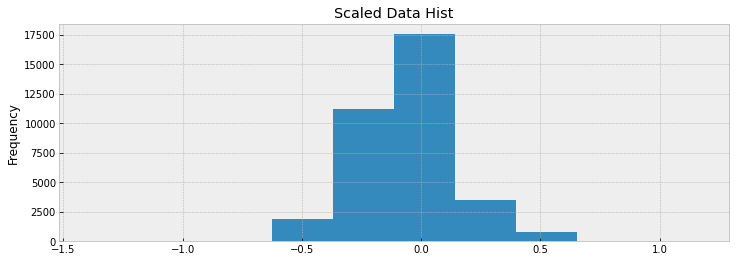

In [ ]:
elec_df_norm[column_name].plot(kind='hist', ax=plt.gca(), title="Scaled Data Hist")

In [ ]:
model = MQRNN(quantiles, history_len, horizon_len, features_size, 
              0, num_layers, hidden_units, context_size,
              global_mlp_layers_sizes = [1000, 300],
              local_mlp_layers_sizes = [1000, 300],)
data = ElectricityDataModule(elec_df_norm, batch_size=batch_len, col=column_name,
                             workers=workers_num, factor=0.5, 
                             history_len=history_len, horizon_len=horizon_len)
gpu_count = 1 if selected_device == "cuda" else None
tpu_cores = 8 if selected_device == "tpu" else None
trainer = Trainer(max_epochs=5, progress_bar_refresh_rate=1, gpus=gpu_count, 
                  tpu_cores=tpu_cores)
trainer.fit(model, data)
trainer.test()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name     | Type    | Params
-------------------------------------
0 | _encoder | Encoder | 150 K 
1 | _decoder | Decoder | 705 K 
-------------------------------------
855 K     Trainable params
0         Non-trainable params
855 K     Total params
3.424     Total estimated model params size (MB)


Train set size: 13152
Val set size: 8760



Test set size: 4380



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.44824451208114624}
--------------------------------------------------------------------------------


[{'test_loss': 0.44824451208114624}]

# Results & Graph

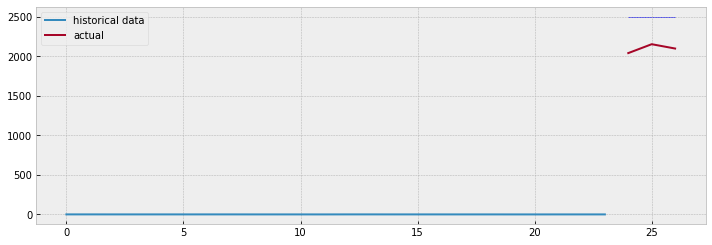

In [ ]:
ds = data.train_ds
hist_sample = torch.cat([ds[32][0].unsqueeze(0), 
                         ds[5][0].unsqueeze(0)]).to(selected_device)
fct_sample = torch.cat([ds[32][1].unsqueeze(0),
                        ds[5][1].unsqueeze(0)])

hist_sample = hist_sample.unsqueeze(2)
forecast_indices = np.arange(history_len, history_len + horizon_len, 1)
quantiles_predictions = model(hist_sample).cpu().detach().numpy()

quantiles_predictions = un_scale(quantiles_predictions, LIML, LIMH)
first_predictions_90p = quantiles_predictions[0, :, 0, 1]
first_predictions_10p = quantiles_predictions[0, :, 0, 0]
fct_sample = un_scale(fct_sample, LIML, LIMH)
plt.plot(hist_sample.cpu()[0], label="historical data")
plt.plot(forecast_indices, fct_sample[0], label="actual")
plt.fill_between(forecast_indices, first_predictions_90p,
                 first_predictions_10p, color='b', alpha=0.7)
plt.legend(loc=0)

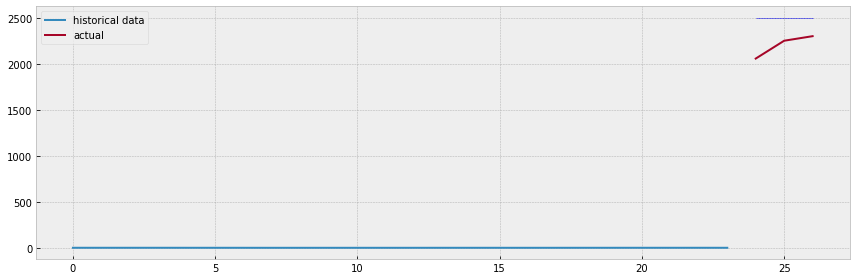

In [ ]:
second_predictions_90p = quantiles_predictions[1, :, 0, 1]
second_predictions_10p = quantiles_predictions[1, :, 0, 0]
plt.plot(hist_sample.cpu()[1], label="historical data")
plt.plot(forecast_indices, fct_sample[1], label="actual")
plt.fill_between(forecast_indices, second_predictions_10p, 
                 second_predictions_90p, color='b', alpha=0.7)
plt.legend(loc=0)
plt.tight_layout()